# Cake Classification
## Machine Learning Course Project
---
### Author: Andrea Alberti  
### Date: May 2023
---
## Data: 
The data set contains 120 images for each of 15 kinds of cake. For each class 100 images
are in the training set and 20 form the test set. All the images have been resized to
224 × 224 pixels.

## Goal:
Build classifiers for the classification of images of cakes.

---

In [1]:
import CC_functions as ccf
import numpy as np
import matplotlib.pyplot as plt
import os
import image_features
import pvml
import pandas as pd

### 1.1 LOW LEVEL FEATURES
##### Write a script that computes one of the low-level feature vector implemented in the image_features.py file. Train a classifier and evaluate the test accuracy.

In [ ]:
#EXTRACT LOW-LEVEL FEATURES (COLOR HISTOGRAMS) FROM IMAGES
classes = os.listdir("Data_gitignore/cake-classification/test")

X, Y = ccf.dir_feat_extract("Data_gitignore/cake-classification/test", classes, extract_method='CH')
print("test", X.shape, Y.shape)
data = np.concatenate([X, Y[:, None]], 1)
np.savetxt("Features/CH_test.txt.gz", data)

X, Y = ccf.dir_feat_extract("Data_gitignore/cake-classification/train", classes, extract_method='CH')
print("train", X.shape, Y.shape)
data = np.concatenate([X, Y[:, None]], 1)
np.savetxt("Features/CH_train.txt.gz", data)

In [ ]:
#TRAIN A MULTI-LAYER PERCEPTRON TO CLASSIFY THE IMAGES
data = np.loadtxt("Features/CH_train.txt.gz")
X_train = data[:, :-1]
Y_train = data[:, -1].astype(int)

data = np.loadtxt("Features/CH_test.txt.gz")
Xtest = data[:, :-1]
Ytest = data[:, -1].astype(int)

nclasses = Y_train.max() + 1

mlp = pvml.MLP([X_train.shape[1], nclasses])
epochs = 5000
batch_size = 50
train_accs, test_accs = ccf.train_MLP(mlp, X_train, Y_train, Xtest, Ytest, epochs, batch_size, model_name = 'ch_mlp', filename = 'ch_accs',store_model=True, store_accs = True)

In [ ]:
df_accs = pd.read_csv('Results/CH_accs.csv')
df_accs.plot(x = 'epoch', y = ['train_acc', 'test_acc'], title = 'Accuracy of MLP with histogram features', xlabel = 'Epoch', ylabel = 'Accuracy (%)')

### 1.2 NEURAL FEATURES
##### Use the pretrained PVMLNet to extract as features the activations of the last hidden layer. Train a perceptron without hidden layers and evaluate the test accuracy.

In [ ]:
classes = os.listdir("Data_gitignore/cake-classification/test")
cnn = pvml.CNN.load("Trained_models/pvmlnet.npz")

X, Y = ccf.dir_feat_neural("Data_gitignore/cake-classification/test", cnn, classes)
print("test", X.shape, Y.shape)
data = np.concatenate([X, Y[:, None]], 1)
np.savetxt("Features/neural_test.txt.gz", data)


X, Y = ccf.dir_feat_neural("Data_gitignore/cake-classification/train", cnn, classes)
print("train", X.shape, Y.shape)
data = np.concatenate([X, Y[:, None]], 1)
np.savetxt("Features/neural_train.txt.gz", data)

In [ ]:
#TRAIN A MULTI-LAYER PERCEPTRON TO CLASSIFY THE IMAGES
data = np.loadtxt("Features/neural_train.txt.gz")
X_train = data[:, :-1]
Y_train = data[:, -1].astype(int)

data = np.loadtxt("Features/neural_test.txt.gz")
X_test = data[:, :-1]
Y_test = data[:, -1].astype(int)

nclasses = Y_train.max() + 1

mlp = pvml.MLP([X_train.shape[1], nclasses])
epochs = 5000
batch_size = 50
train_accs, test_accs = ccf.train_MLP(mlp, X_train, Y_train, X_test, Y_test, epochs, batch_size, model_name = 'cnn_mlp', filename = 'cnn_accs',store_model=True, store_accs = True)

In [ ]:
df_accs = pd.read_csv('Results/cnn_accs.csv')
df_accs.plot(x = 'epoch', y = ['train_acc', 'test_acc'], title = 'Accuracy of MLP with histogram features', xlabel = 'Epoch', ylabel = 'Accuracy (%)')

### 1.3 TRANSFER LEARNING
##### Build a new network by replacing the last layer of PVMLNet with the weights of the trained perceptron.

In [2]:
cnn = pvml.CNN.load('Trained_models/pvmlnet.npz')
mlp = pvml.MLP.load('Trained_models/cnn_mlp.npz')


cnn.weights[-1] = mlp.weights[0][None, None, :, :]
cnn.biases[-1] = mlp.biases[0]

cnn.save("Trained_models/cnn_transfer_gitignore.npz")

classes = os.listdir('Data_gitignore/cake-classification/test')
imagename = 'ice_cream/45200.jpg'

ccf.item_prediction(imagename, classes, cnn)



(['cannoli', 'apple_pie', 'creme_brulee', 'churros', 'ice_cream'],
 [87.80131487646555,
  11.782060192107584,
  0.2711074325122126,
  0.06799924561037596,
  0.06604862988794301])

In [30]:

data = np.loadtxt("Features/neural_train.txt.gz")
X_train = data[:, :-1]
Y_train = data[:, -1].astype(int)

data = np.loadtxt("Features/neural_test.txt.gz")
X_test = data[:, :-1]
Y_test = data[:, -1].astype(int)

classes = os.listdir("Data_gitignore/cake-classification/test")
path = "Data_gitignore/cake-classification/test"

cnn_transfer = pvml.CNN.load('Trained_models/cnn_transfer_gitignore.npz')
all_predictions = []
for klass_label, klass in enumerate(classes):
    image_files = os.listdir(path + "/" + klass)
    for imagename in image_files:
        image_path = path + "/" + klass + "/" + imagename
        image = plt.imread(image_path) / 255.0
        #print(image_path)
        prediction = cnn_transfer.inference(image[None, :, :, :])
        all_predictions.append(prediction)

predicted_labels = np.array([0] * 300)
for i in range(300):
    predicted_labels[i] = np.argmax(all_predictions[i][1])
test_acc = (predicted_labels==Y_test).mean()
print("Test accuracy: ", test_acc)

Test accuracy:  0.8033333333333333


0.8033333333333333

### 2.1 COMBINING FEATURES
##### Try different combinations of low-level features (concatenate two or more feature vectors with np.concatenate).

| FEATURES COMBINATION |
| --- |
| color histogram + edge direction |
| color histogram + co-occurrence matrix |
| edge direction + co-occurrence matrix |
| color histogram + + edge direction + co-occurrence matrix |


In [ ]:
#EXTRACT OTHERS LOW-LEVEL FEATURES FROM IMAGES
classes = os.listdir("Data_gitignore/cake-classification/test")

#EDGE DIRECTION HISTOGRAM
X, Y = ccf.dir_feat_extract("Data_gitignore/cake-classification/test", classes, extract_method='EDH')
print("test", X.shape, Y.shape)
data = np.concatenate([X, Y[:, None]], 1)
np.savetxt("Features/EDH_test.txt.gz", data)

X, Y = ccf.dir_feat_extract("Data_gitignore/cake-classification/train", classes, extract_method='EDH')
print("train", X.shape, Y.shape)
data = np.concatenate([X, Y[:, None]], 1)
np.savetxt("Features/EDH_train.txt.gz", data)


#COOCCURRENCE MATRIX
X, Y = ccf.dir_feat_extract("Data_gitignore/cake-classification/test", classes, extract_method='CM')
print("test", X.shape, Y.shape)
data = np.concatenate([X, Y[:, None]], 1)
np.savetxt("Features/CM_test.txt.gz", data)

X, Y = ccf.dir_feat_extract("Data_gitignore/cake-classification/train", classes, extract_method='CM')
print("train", X.shape, Y.shape)
data = np.concatenate([X, Y[:, None]], 1)
np.savetxt("Features/CM_train.txt.gz", data)


Load the different features

In [ ]:
#load the various features
CH_features = np.loadtxt("Features/CH_test.txt.gz")
X_CH_test = CH_features[:, :-1]
Y_CH_test = CH_features[:, -1].astype(int)
CH_features = np.loadtxt("Features/CH_train.txt.gz")
X_CH_train = CH_features[:, :-1]
Y_CH_train = CH_features[:, -1].astype(int)

EDH_features = np.loadtxt("Features/EDH_test.txt.gz")
X_EDH_test = EDH_features[:, :-1]
Y_EDH_test = EDH_features[:, -1].astype(int)
EDH_features = np.loadtxt("Features/EDH_train.txt.gz")
X_EDH_train = EDH_features[:, :-1]
Y_EDH_train = EDH_features[:, -1].astype(int)

CM_features = np.loadtxt("Features/CM_test.txt.gz")
X_CM_test = CM_features[:, :-1]
Y_CM_test = CM_features[:, -1].astype(int)
CM_features = np.loadtxt("Features/CM_train.txt.gz")
X_CM_train = CM_features[:, :-1]
Y_CM_train = CM_features[:, -1].astype(int)

In [ ]:
feature_names = ['CH_test', 'CH_train', 'EDH_test', 'EDH_train', 'CM_test', 'CM_train']
features_list = ccf.load_features(feature_names)
X_CH_test, Y_CH_test, X_CH_train, Y_CH_train, X_EDH_test, Y_EDH_test, X_EDH_train, Y_EDH_train, X_CM_test, Y_CM_test, X_CM_train, Y_CM_train = features_list

Concatenate the features to get various combinations (listed in above table). Store the new features.

In [ ]:
#CONCATENATE FEATURES IN DIFFERENT COMBINATIONS

#HISTOGRAM + EDGE DIRECTION HISTOGRAM
X_test_CH_EDH = np.concatenate([X_CH_test, X_EDH_test], 1)
data = np.concatenate([X_test_CH_EDH, Y_CH_test[:, None]], 1)
np.savetxt("Features/CH_EDH_test.txt.gz", data)

X_train_CH_EDH = np.concatenate([X_CH_train, X_EDH_train], 1)
data = np.concatenate([X_train_CH_EDH, Y_CH_train[:, None]], 1)
np.savetxt("Features/CH_EDH_train.txt.gz", data)


#HISTOGRAM + COOCCURRENCE MATRIX
X_test_CH_CM = np.concatenate([X_CH_test, X_CM_test], 1)
data = np.concatenate([X_test_CH_CM, Y_CH_test[:, None]], 1)
np.savetxt("Features/CH_CM_test.txt.gz", data)

X_train_CH_CM = np.concatenate([X_CH_train, X_CM_train], 1)
data = np.concatenate([X_train_CH_CM, Y_CH_train[:, None]], 1)
np.savetxt("Features/CH_CM_train.txt.gz", data)


#EDGE DIRECTION HISTOGRAM + COOCCURRENCE MATRIX
X_test_EDH_CM = np.concatenate([X_EDH_test, X_CM_test], 1)
data = np.concatenate([X_test_EDH_CM, Y_CH_test[:, None]], 1)
np.savetxt("Features/EDH_CM_test.txt.gz", data)

X_train_EDH_CM = np.concatenate([X_EDH_train, X_CM_train], 1)
data = np.concatenate([X_train_EDH_CM, Y_CH_train[:, None]], 1)
np.savetxt("Features/EDH_CM_train.txt.gz", data)


#HISTOGRAM + EDGE DIRECTION HISTOGRAM + COOCCURRENCE MATRIX
X_test_CH_EDH_CM = np.concatenate([X_CH_test, X_EDH_test, X_CM_test], 1)
data = np.concatenate([X_test_CH_EDH_CM, Y_CH_test[:, None]], 1)
np.savetxt("Features/CH_EDH_CM_test.txt.gz", data)

X_train_CH_EDH_CM = np.concatenate([X_CH_train, X_EDH_train, X_CM_train], 1)
data = np.concatenate([X_train_CH_EDH_CM, Y_CH_train[:, None]], 1)
np.savetxt("Features/CH_EDH_CM_train.txt.gz", data)


In [ ]:
#HISTOGRAM + EDGE DIRECTION HISTOGRAM
X_test_CH_EDH, X_train_CH_EDH = ccf.concatenate_features([X_CH_test, X_EDH_test], [X_CH_train, X_EDH_train], Y_test, Y_train, 'CH_EDH_test', 'CH_EDH_train', store = True)

#HISTOGRAM + COOCCURRENCE MATRIX
X_test_CH_CM, X_train_CH_CM = ccf.concatenate_features([X_CH_test, X_CM_test], [X_CH_train, X_CM_train], Y_test, Y_train, 'CH_CM_test', 'CH_CM_train', store = True)

#EDGE DIRECTION HISTOGRAM + COOCCURRENCE MATRIX
X_test_EDH_CM, X_train_EDH_CM = ccf.concatenate_features([X_EDH_test, X_CM_test], [X_EDH_train, X_CM_train], Y_test, Y_train, 'EDH_CM_test', 'EDH_CM_train', store = True)

#HISTOGRAM + EDGE DIRECTION HISTOGRAM + COOCCURRENCE MATRIX
X_test_CH_EDH_CM, X_train_CH_EDH_CM = ccf.concatenate_features([X_CH_test, X_EDH_test, X_CM_test], [X_CH_train, X_EDH_train, X_CM_train], Y_test, Y_train, 'CH_EDH_CM_test', 'CH_EDH_CM_train', store = True)


Load the stored combined features and train a classifier. Evaluate the test accuracy.

In [ ]:
#train and test a multilayer perceptron on the various features

#CH_EDH
data = np.loadtxt("Features/CH_EDH_train.txt.gz")
X_train = data[:, :-1]
Y_train = data[:, -1].astype(int)

data = np.loadtxt("Features/CH_EDH_test.txt.gz")
X_test = data[:, :-1]
Y_test = data[:, -1].astype(int)

nclasses = Y_train.max() + 1

mlp = pvml.MLP([X_train.shape[1], nclasses])
epochs = 5000
batch_size = 50
train_accs, test_accs = ccf.train_MLP(mlp, X_train, Y_train, X_test, Y_test, epochs, batch_size, model_name = 'ch_edh_mlp', filename = 'ch_edh_accs',store_model=True, store_accs = True)


#CH_CM
data = np.loadtxt("Features/CH_CM_train.txt.gz")
X_train = data[:, :-1]
Y_train = data[:, -1].astype(int)

data = np.loadtxt("Features/CH_CM_test.txt.gz")
X_test = data[:, :-1]
Y_test = data[:, -1].astype(int)

nclasses = Y_train.max() + 1

mlp = pvml.MLP([X_train.shape[1], nclasses])
epochs = 5000
batch_size = 50
train_accs, test_accs = ccf.train_MLP(mlp, X_train, Y_train, X_test, Y_test, epochs, batch_size, model_name = 'ch_cm_mlp', filename = 'ch_cm_accs',store_model=True, store_accs = True)


#EDH_CM
data = np.loadtxt("Features/EDH_CM_train.txt.gz")
X_train = data[:, :-1]
Y_train = data[:, -1].astype(int)

data = np.loadtxt("Features/EDH_CM_test.txt.gz")
X_test = data[:, :-1]
Y_test = data[:, -1].astype(int)

nclasses = Y_train.max() + 1

mlp = pvml.MLP([X_train.shape[1], nclasses])
epochs = 5000
batch_size = 50
train_accs, test_accs = ccf.train_MLP(mlp, X_train, Y_train, X_test, Y_test, epochs, batch_size, model_name = 'edh_cm_mlp', filename = 'edh_cm_accs',store_model=True, store_accs = True)


#CH_EDH_CM
data = np.loadtxt("Features/CH_EDH_CM_train.txt.gz")
X_train = data[:, :-1]
Y_train = data[:, -1].astype(int)

data = np.loadtxt("Features/CH_EDH_CM_test.txt.gz")
X_test = data[:, :-1]
Y_test = data[:, -1].astype(int)

nclasses = Y_train.max() + 1

mlp = pvml.MLP([X_train.shape[1], nclasses])
epochs = 5000
batch_size = 50
train_accs, test_accs = ccf.train_MLP(mlp, X_train, Y_train, X_test, Y_test, epochs, batch_size, model_name = 'ch_edh_cm_mlp', filename = 'ch_edh_cm_accs',store_model=True, store_accs = True)

In [ ]:
features_list = ccf.load_features(['CH_EDH_test', 'CH_EDH_train', 'CH_CM_test', 'CH_CM_train', 'EDH_CM_test', 'EDH_CM_train', 'CH_EDH_CM_test', 'CH_EDH_CM_train'])
names = ['ch_edh', 'ch_cm', 'edh_cm', 'ch_edh_cm']

j = 0
for i in range(0, len(features_list), 4):
    X_test = features_list[i]
    Y_test = features_list[i+1]
    X_train = features_list[i+2]
    Y_train = features_list[i+3]
    
    nclasses = Y_train.max() + 1

    mlp = pvml.MLP([X_train.shape[1], nclasses])
    epochs = 5000
    batch_size = 50
    train_accs, test_accs = ccf.train_MLP(mlp, X_train, Y_train, X_test, Y_test, epochs, batch_size, model_name = f'{names[j]}_mlp', filename = f'{names[j]}_accs',store_model=True, store_accs = True)
    j += 1


Plot the results

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

#CH-EDH
df_accs = pd.read_csv('Results/ch_edh_accs.csv')
df_accs.plot(x = 'epoch', y = ['train_acc', 'test_acc'], title = 'CH-EDH features', ax=axs[0], legend = False, xlabel='')
axs[0].set_ylim([3, 27.5])

#CH-CM
df_accs = pd.read_csv('Results/ch_cm_accs.csv')
df_accs.plot(x = 'epoch', y = ['train_acc', 'test_acc'], title = 'CH-CM features', ax=axs[1], legend=False,xlabel='')
axs[1].set_ylim([3, 27.5])

#EDH-CM
df_accs = pd.read_csv('Results/edh_cm_accs.csv')
df_accs.plot(x = 'epoch', y = ['train_acc', 'test_acc'], title = 'EDH-CM features', ax=axs[2],  legend=False,xlabel='')
axs[2].set_ylim([3, 27.5])

#CH-EDH-CM
df_accs = pd.read_csv('Results/ch_edh_cm_accs.csv')
df_accs.plot(x = 'epoch', y = ['train_acc', 'test_acc'], title = 'CH-EDH-CM features', ax=axs[3], legend=False,xlabel='')
axs[3].set_ylim([3, 27.5])

#title
fig.suptitle('Accuracy of MLPs with different features', fontsize=14)
fig.text(0.5, -0.03, "Epochs (x 100)", ha='center', fontsize=13)
fig.text(-0.03, 0.5, "Accuracy (%)", va='center', rotation='vertical', fontsize=13)
fig.legend(['Train', 'Test'], loc = 'center', bbox_to_anchor=(0.5, -0.07), ncol=2)
fig.tight_layout()

Do the same but using features normalized with MEAN-VAR

In [ ]:
#train and test a multilayer perceptron on the various NORMALIZED (MEAN-VAR) features

#CH_EDH
data = np.loadtxt("Features/CH_EDH_train.txt.gz")
X_train = data[:, :-1]
Y_train = data[:, -1].astype(int)

data = np.loadtxt("Features/CH_EDH_test.txt.gz")
X_test = data[:, :-1]
Y_test = data[:, -1].astype(int)

X_train, X_test = ccf.mean_var_normalize(X_train, X_test)

nclasses = Y_train.max() + 1

mlp = pvml.MLP([X_train.shape[1], nclasses])
epochs = 5000
batch_size = 50
train_accs, test_accs = ccf.train_MLP(mlp, X_train, Y_train, X_test, Y_test, epochs, batch_size, model_name = 'ch_edh_mvar_mlp', filename = 'ch_edh_mvar_accs',store_model=True, store_accs = True)


#CH_CM
data = np.loadtxt("Features/CH_CM_train.txt.gz")
X_train = data[:, :-1]
Y_train = data[:, -1].astype(int)

data = np.loadtxt("Features/CH_CM_test.txt.gz")
X_test = data[:, :-1]
Y_test = data[:, -1].astype(int)

X_train, X_test = ccf.mean_var_normalize(X_train, X_test)

nclasses = Y_train.max() + 1

mlp = pvml.MLP([X_train.shape[1], nclasses])
epochs = 5000
batch_size = 50
train_accs, test_accs = ccf.train_MLP(mlp, X_train, Y_train, X_test, Y_test, epochs, batch_size, model_name = 'ch_cm_mvar_mlp', filename = 'ch_cm_mvar_accs',store_model=True, store_accs = True)


#EDH_CM
data = np.loadtxt("Features/EDH_CM_train.txt.gz")
X_train = data[:, :-1]
Y_train = data[:, -1].astype(int)

data = np.loadtxt("Features/EDH_CM_test.txt.gz")
X_test = data[:, :-1]
Y_test = data[:, -1].astype(int)

X_train, X_test = ccf.mean_var_normalize(X_train, X_test)

nclasses = Y_train.max() + 1

mlp = pvml.MLP([X_train.shape[1], nclasses])
epochs = 5000
batch_size = 50
train_accs, test_accs = ccf.train_MLP(mlp, X_train, Y_train, X_test, Y_test, epochs, batch_size, model_name = 'edh_cm_mvar_mlp', filename = 'edh_cm_mvar_accs',store_model=True, store_accs = True)


#CH_EDH_CM
data = np.loadtxt("Features/CH_EDH_CM_train.txt.gz")
X_train = data[:, :-1]
Y_train = data[:, -1].astype(int)

data = np.loadtxt("Features/CH_EDH_CM_test.txt.gz")
X_test = data[:, :-1]
Y_test = data[:, -1].astype(int)

X_train, X_test = ccf.mean_var_normalize(X_train, X_test)

nclasses = Y_train.max() + 1

mlp = pvml.MLP([X_train.shape[1], nclasses])
epochs = 5000
batch_size = 50
train_accs, test_accs = ccf.train_MLP(mlp, X_train, Y_train, X_test, Y_test, epochs, batch_size, model_name = 'ch_edh_cm_mvar_mlp', filename = 'ch_edh_cm_mvar_accs',store_model=True, store_accs = True)



In [ ]:
features_list = ccf.load_features(['CH_EDH_test', 'CH_EDH_train', 'CH_CM_test', 'CH_CM_train', 'EDH_CM_test', 'EDH_CM_train', 'CH_EDH_CM_test', 'CH_EDH_CM_train'])
names = ['ch_edh', 'ch_cm', 'edh_cm', 'ch_edh_cm']

j = 0
for i in range(0, len(features_list), 4):
    X_test = features_list[i]
    Y_test = features_list[i+1]
    X_train = features_list[i+2]
    Y_train = features_list[i+3]
    
    nclasses = Y_train.max() + 1
    
    #mean-var normalization
    X_train_norm, X_test_norm = ccf.mean_var_normalize(X_train, X_test)

    mlp = pvml.MLP([X_train_norm.shape[1], nclasses])
    epochs = 5000
    batch_size = 50
    train_accs, test_accs = ccf.train_MLP(mlp, X_train_norm, Y_train, X_test_norm, Y_test, epochs, batch_size, model_name = f'{names[j]}_mvar_mlp', filename = f'{names[j]}_mvar_accs',store_model=True, store_accs = True)
    
    #min-max normalization
    X_train_norm, X_test_norm = ccf.min_max_normalize(X_train, X_test)

    mlp = pvml.MLP([X_train_norm.shape[1], nclasses])
    epochs = 5000
    batch_size = 50
    train_accs, test_accs = ccf.train_MLP(mlp, X_train_norm, Y_train, X_test_norm, Y_test, epochs, batch_size, model_name = f'{names[j]}_minmax_mlp', filename = f'{names[j]}_minmax_accs',store_model=True, store_accs = True)
    
    #whitening normalization
    X_train_norm, X_test_norm = ccf.mean_var_normalize(X_train, X_test)

    mlp = pvml.MLP([X_train_norm.shape[1], nclasses])
    epochs = 5000
    batch_size = 50
    train_accs, test_accs = ccf.train_MLP(mlp, X_train_norm, Y_train, X_test_norm, Y_test, epochs, batch_size, model_name = f'{names[j]}_white_mlp', filename = f'{names[j]}_white_accs',store_model=True, store_accs = True)
    j += 1
    
    

Plot the results

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

#CH-EDH
df_accs = pd.read_csv('Results/ch_edh_mvar_accs.csv')
df_accs.plot(x = 'epoch', y = ['train_acc', 'test_acc'], title = 'CH-EDH features', ax=axs[0], legend = False, xlabel='')
axs[0].set_ylim([5, 95])

#CH-CM
df_accs = pd.read_csv('Results/ch_cm_mvar_accs.csv')
df_accs.plot(x = 'epoch', y = ['train_acc', 'test_acc'], title = 'CH-CM features', ax=axs[1], legend=False,xlabel='')
axs[1].set_ylim([5, 95])

#EDH-CM
df_accs = pd.read_csv('Results/edh_cm_mvar_accs.csv')
df_accs.plot(x = 'epoch', y = ['train_acc', 'test_acc'], title = 'EDH-CM features', ax=axs[2],  legend=False,xlabel='')
axs[2].set_ylim([5, 95])

#CH-EDH-CM
df_accs = pd.read_csv('Results/ch_edh_cm_mvar_accs.csv')
df_accs.plot(x = 'epoch', y = ['train_acc', 'test_acc'], title = 'CH-EDH-CM features', ax=axs[3], legend=False,xlabel='')
axs[3].set_ylim([5, 95])

#title
fig.suptitle('Accuracy of MLPs with different features', fontsize=14)
fig.text(0.5, -0.03, "Epochs (x 100)", ha='center', fontsize=13)
fig.text(-0.03, 0.5, "Accuracy (%)", va='center', rotation='vertical', fontsize=13)
fig.legend(['Train', 'Test'], loc = 'center', bbox_to_anchor=(0.5, -0.07), ncol=2)
fig.tight_layout()

Normalize with MIN MAX

In [ ]:
#train and test a multilayer perceptron on the various NORMALIZED (MIN-MAX) features

#CH_EDH
data = np.loadtxt("Features/CH_EDH_train.txt.gz")
X_train = data[:, :-1]
Y_train = data[:, -1].astype(int)

data = np.loadtxt("Features/CH_EDH_test.txt.gz")
X_test = data[:, :-1]
Y_test = data[:, -1].astype(int)

X_train, X_test = ccf.min_max_normalize(X_train, X_test)

nclasses = Y_train.max() + 1

mlp = pvml.MLP([X_train.shape[1], nclasses])
epochs = 5000
batch_size = 50
train_accs, test_accs = ccf.train_MLP(mlp, X_train, Y_train, X_test, Y_test, epochs, batch_size, model_name = 'ch_edh_minmax_mlp', filename = 'ch_edh_minmax_accs',store_model=True, store_accs = True)


#CH_CM
data = np.loadtxt("Features/CH_CM_train.txt.gz")
X_train = data[:, :-1]
Y_train = data[:, -1].astype(int)

data = np.loadtxt("Features/CH_CM_test.txt.gz")
X_test = data[:, :-1]
Y_test = data[:, -1].astype(int)

X_train, X_test = ccf.min_max_normalize(X_train, X_test)

nclasses = Y_train.max() + 1

mlp = pvml.MLP([X_train.shape[1], nclasses])
epochs = 5000
batch_size = 50
train_accs, test_accs = ccf.train_MLP(mlp, X_train, Y_train, X_test, Y_test, epochs, batch_size, model_name = 'ch_cm_minmax_mlp', filename = 'ch_cm_minmax_accs',store_model=True, store_accs = True)


#EDH_CM
data = np.loadtxt("Features/EDH_CM_train.txt.gz")
X_train = data[:, :-1]
Y_train = data[:, -1].astype(int)

data = np.loadtxt("Features/EDH_CM_test.txt.gz")
X_test = data[:, :-1]
Y_test = data[:, -1].astype(int)

X_train, X_test = ccf.min_max_normalize(X_train, X_test)

nclasses = Y_train.max() + 1

mlp = pvml.MLP([X_train.shape[1], nclasses])
epochs = 5000
batch_size = 50
train_accs, test_accs = ccf.train_MLP(mlp, X_train, Y_train, X_test, Y_test, epochs, batch_size, model_name = 'edh_cm_minmax_mlp', filename = 'edh_cm_minmax_accs',store_model=True, store_accs = True)


#CH_EDH_CM
data = np.loadtxt("Features/CH_EDH_CM_train.txt.gz")
X_train = data[:, :-1]
Y_train = data[:, -1].astype(int)

data = np.loadtxt("Features/CH_EDH_CM_test.txt.gz")
X_test = data[:, :-1]
Y_test = data[:, -1].astype(int)

X_train, X_test = ccf.min_max_normalize(X_train, X_test)

nclasses = Y_train.max() + 1

mlp = pvml.MLP([X_train.shape[1], nclasses])
epochs = 5000
batch_size = 50
train_accs, test_accs = ccf.train_MLP(mlp, X_train, Y_train, X_test, Y_test, epochs, batch_size, model_name = 'ch_edh_cm_minmax_mlp', filename = 'ch_edh_cm_minmax_accs',store_model=True, store_accs = True)

Plot the results

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

#CH-EDH
df_accs = pd.read_csv('Results/ch_edh_minmax_accs.csv')
df_accs.plot(x = 'epoch', y = ['train_acc', 'test_acc'], title = 'CH-EDH features', ax=axs[0], legend = False, xlabel='')
axs[0].set_ylim([5, 60])

#CH-CM
df_accs = pd.read_csv('Results/ch_cm_minmax_accs.csv')
df_accs.plot(x = 'epoch', y = ['train_acc', 'test_acc'], title = 'CH-CM features', ax=axs[1], legend=False,xlabel='')
axs[1].set_ylim([5, 60])

#EDH-CM
df_accs = pd.read_csv('Results/edh_cm_minmax_accs.csv')
df_accs.plot(x = 'epoch', y = ['train_acc', 'test_acc'], title = 'EDH-CM features', ax=axs[2],  legend=False,xlabel='')
axs[2].set_ylim([5, 60])

#CH-EDH-CM
df_accs = pd.read_csv('Results/ch_edh_cm_minmax_accs.csv')
df_accs.plot(x = 'epoch', y = ['train_acc', 'test_acc'], title = 'CH-EDH-CM features', ax=axs[3], legend=False,xlabel='')
axs[3].set_ylim([5, 60])

#title
fig.suptitle('Accuracy of MLPs with different features', fontsize=14)
fig.text(0.5, -0.03, "Epochs (x 100)", ha='center', fontsize=13)
fig.text(-0.03, 0.5, "Accuracy (%)", va='center', rotation='vertical', fontsize=13)
fig.legend(['Train', 'Test'], loc = 'center', bbox_to_anchor=(0.5, -0.07), ncol=2)
fig.tight_layout()

Normalize with whitening

In [ ]:
#train and test a multilayer perceptron on the various NORMALIZED (WHITENING) features

#CH_EDH
data = np.loadtxt("Features/CH_EDH_train.txt.gz")
X_train = data[:, :-1]
Y_train = data[:, -1].astype(int)

data = np.loadtxt("Features/CH_EDH_test.txt.gz")
X_test = data[:, :-1]
Y_test = data[:, -1].astype(int)

X_train, X_test = ccf.whitening_normalize(X_train, X_test)

nclasses = Y_train.max() + 1

mlp = pvml.MLP([X_train.shape[1], nclasses])
epochs = 5000
batch_size = 50
train_accs, test_accs = ccf.train_MLP(mlp, X_train, Y_train, X_test, Y_test, epochs, batch_size, model_name = 'ch_edh_white_mlp', filename = 'ch_edh_white_accs',store_model=True, store_accs = True)


#CH_CM
data = np.loadtxt("Features/CH_CM_train.txt.gz")
X_train = data[:, :-1]
Y_train = data[:, -1].astype(int)

data = np.loadtxt("Features/CH_CM_test.txt.gz")
X_test = data[:, :-1]
Y_test = data[:, -1].astype(int)

X_train, X_test = ccf.whitening_normalize(X_train, X_test)

nclasses = Y_train.max() + 1

mlp = pvml.MLP([X_train.shape[1], nclasses])
epochs = 5000
batch_size = 50
train_accs, test_accs = ccf.train_MLP(mlp, X_train, Y_train, X_test, Y_test, epochs, batch_size, model_name = 'ch_cm_white_mlp', filename = 'ch_cm_white_accs',store_model=True, store_accs = True)


#EDH_CM
data = np.loadtxt("Features/EDH_CM_train.txt.gz")
X_train = data[:, :-1]
Y_train = data[:, -1].astype(int)

data = np.loadtxt("Features/EDH_CM_test.txt.gz")
X_test = data[:, :-1]
Y_test = data[:, -1].astype(int)

X_train, X_test = ccf.whitening_normalize(X_train, X_test)

nclasses = Y_train.max() + 1

mlp = pvml.MLP([X_train.shape[1], nclasses])
epochs = 5000
batch_size = 50
train_accs, test_accs = ccf.train_MLP(mlp, X_train, Y_train, X_test, Y_test, epochs, batch_size, model_name = 'edh_cm_white_mlp', filename = 'edh_cm_white_accs',store_model=True, store_accs = True)


#CH_EDH_CM
data = np.loadtxt("Features/CH_EDH_CM_train.txt.gz")
X_train = data[:, :-1]
Y_train = data[:, -1].astype(int)

data = np.loadtxt("Features/CH_EDH_CM_test.txt.gz")
X_test = data[:, :-1]
Y_test = data[:, -1].astype(int)

X_train, X_test = ccf.whitening_normalize(X_train, X_test)

nclasses = Y_train.max() + 1

mlp = pvml.MLP([X_train.shape[1], nclasses])
epochs = 5000
batch_size = 50
train_accs, test_accs = ccf.train_MLP(mlp, X_train, Y_train, X_test, Y_test, epochs, batch_size, model_name = 'ch_edh_cm_white_mlp', filename = 'ch_edh_cm_white_accs',store_model=True, store_accs = True)

Plot the results

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

#CH-EDH
df_accs = pd.read_csv('Results/ch_edh_white_accs.csv')
df_accs.plot(x = 'epoch', y = ['train_acc', 'test_acc'], title = 'CH-EDH features', ax=axs[0], legend = False, xlabel='')
axs[0].set_ylim([5, 60])

#CH-CM
df_accs = pd.read_csv('Results/ch_cm_white_accs.csv')
df_accs.plot(x = 'epoch', y = ['train_acc', 'test_acc'], title = 'CH-CM features', ax=axs[1], legend=False,xlabel='')
axs[1].set_ylim([5, 60])

#EDH-CM
df_accs = pd.read_csv('Results/edh_cm_white_accs.csv')
df_accs.plot(x = 'epoch', y = ['train_acc', 'test_acc'], title = 'EDH-CM features', ax=axs[2],  legend=False,xlabel='')
axs[2].set_ylim([5, 60])

#CH-EDH-CM
df_accs = pd.read_csv('Results/ch_edh_cm_white_accs.csv')
df_accs.plot(x = 'epoch', y = ['train_acc', 'test_acc'], title = 'CH-EDH-CM features', ax=axs[3], legend=False,xlabel='')
axs[3].set_ylim([5, 60])

#title
fig.suptitle('Accuracy of MLPs with different features', fontsize=14)
fig.text(0.5, -0.03, "Epochs (x 100)", ha='center', fontsize=13)
fig.text(-0.03, 0.5, "Accuracy (%)", va='center', rotation='vertical', fontsize=13)
fig.legend(['Train', 'Test'], loc = 'center', bbox_to_anchor=(0.5, -0.07), ncol=2)
fig.tight_layout()

### 2.2 ANALYSIS
##### Identify the pairs of classes that are more likely to be confused with neural features. Also identify the test images that are misclassified even if the classifier predicted their label with high confidence.

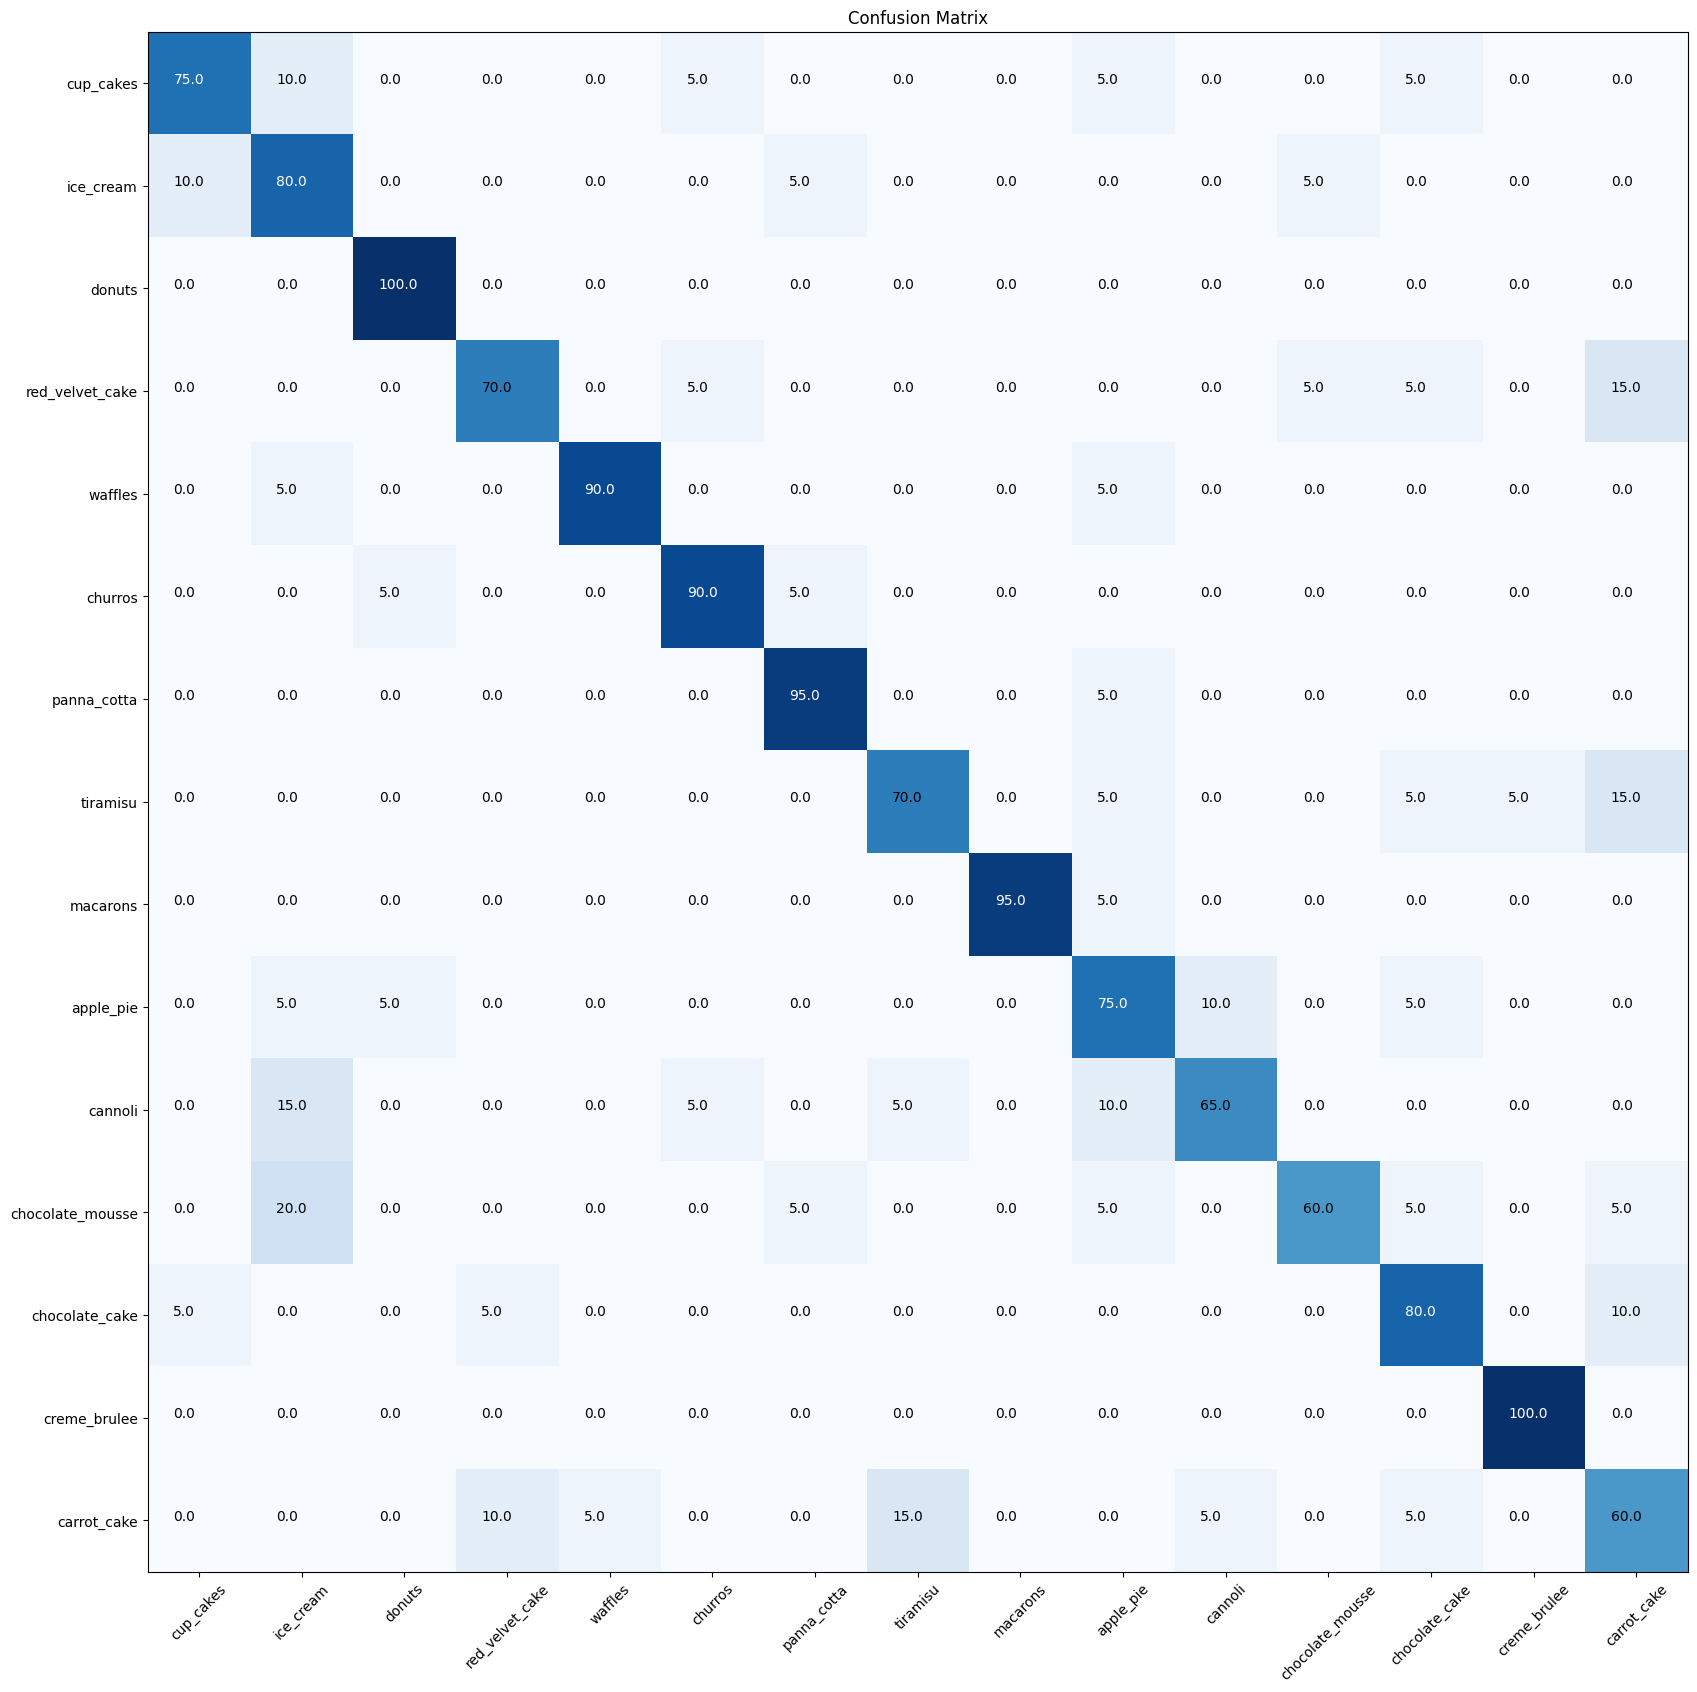

In [2]:
#analysis of the best model
classes = os.listdir('Data_gitignore/cake-classification/test')

data = np.loadtxt("Features/neural_test.txt.gz")
X_test = data[:, :-1]
Y_test = data[:, -1].astype(int)

mlp = pvml.MLP.load('Trained_models/cnn_mlp.npz')
predictions, probs = mlp.inference(X_test)

cm = ccf.confusion_matrix(Y_test, predictions, classes, show = True, rnorm = True)

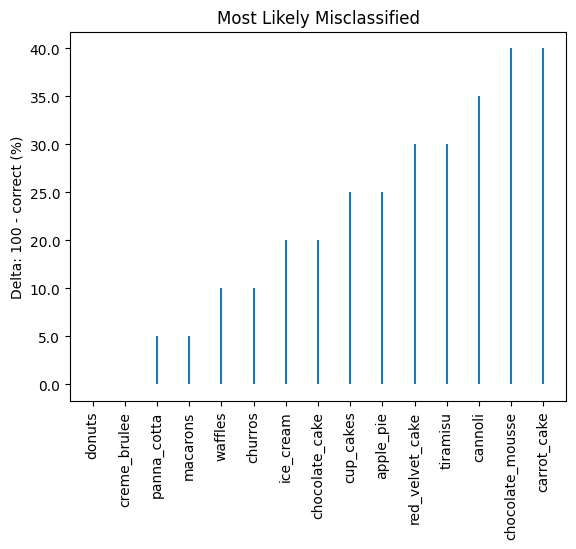

array([['donuts', 'creme_brulee', 'panna_cotta', 'macarons', 'waffles',
        'churros', 'ice_cream', 'chocolate_cake', 'cup_cakes',
        'apple_pie', 'red_velvet_cake', 'tiramisu', 'cannoli',
        'chocolate_mousse', 'carrot_cake'],
       ['0.0', '0.0', '5.0', '5.0', '10.0', '10.0', '20.0', '20.0',
        '25.0', '25.0', '30.0', '30.0', '35.0', '40.0', '40.0'],
       ['20', '20', '20', '20', '20', '20', '20', '20', '20', '20', '20',
        '20', '20', '20', '20']], dtype='<U32')

In [3]:
counters = np.bincount(Y_test)
classes = np.array(classes)
ccf.likely_misclassified(counters, cm, classes, 15, show = True)

the class 'cup_cakes' is frequently exchanged with 'ice_cream'
the class 'ice_cream' is frequently exchanged with 'cup_cakes'
the class 'donuts' is frequently exchanged with 'cup_cakes'
the class 'red_velvet_cake' is frequently exchanged with 'carrot_cake'
the class 'waffles' is frequently exchanged with 'ice_cream'
the class 'churros' is frequently exchanged with 'donuts'
the class 'panna_cotta' is frequently exchanged with 'apple_pie'
the class 'tiramisu' is frequently exchanged with 'carrot_cake'
the class 'macarons' is frequently exchanged with 'apple_pie'
the class 'apple_pie' is frequently exchanged with 'cannoli'
the class 'cannoli' is frequently exchanged with 'ice_cream'
the class 'chocolate_mousse' is frequently exchanged with 'ice_cream'
the class 'chocolate_cake' is frequently exchanged with 'carrot_cake'
the class 'creme_brulee' is frequently exchanged with 'cup_cakes'
the class 'carrot_cake' is frequently exchanged with 'tiramisu'


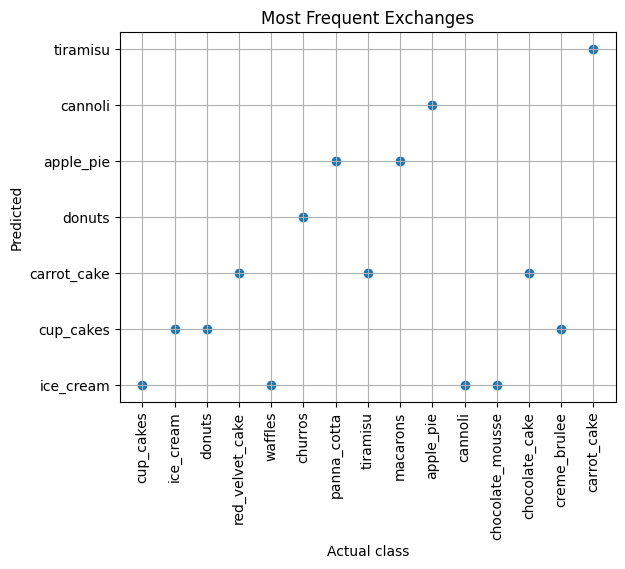

In [4]:
def wrong_classes(cm, classes):
    '''For each class returns the class respect to which it is more likely to be exchanged (with labels and with values)'''
    actuals = [] 
    wrongs = []
    vals = []
    for i in range(15):
        c = np.argmax(cm[i,:])
        if c == i:
            cm[i,c]=0
            c = np.argmax(cm[i,:])
        value = cm[i,c]
        actuals.append(i)
        wrongs.append(c)
        vals.append(value)
    out_valued = np.array([actuals, wrongs, vals])
    out_labelled = np.array([classes[actuals], classes[wrongs]])
    return out_labelled, out_valued

#print most frequet classes exchanges

wrong_labelled, wrong_valued = wrong_classes(cm, classes)
for j in range(15):
    print(f"the class '{wrong_labelled[0,j]}' is frequently exchanged with '{wrong_labelled[1,j]}'")

plt.figure()
plt.scatter(wrong_labelled[0,:], wrong_labelled[1,:])
plt.grid(True)
plt.xticks(rotation=90)
plt.title('Most Frequent Exchanges')
plt.xlabel('Actual class')
plt.ylabel('Predicted')
plt.show()

/tmp/ipykernel_7164/2727784872.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  misclassified_info = np.array([class_names_correct, in_class_pos])


image '1703900.jpg' of class cup_cakes is misclassified as churros
image '125672.jpg' of class cup_cakes is misclassified as apple_pie
image '496329.jpg' of class cup_cakes is misclassified as ice_cream
image '382610.jpg' of class cup_cakes is misclassified as chocolate_cake
image '2838899.jpg' of class cup_cakes is misclassified as ice_cream
image '524372.jpg' of class ice_cream is misclassified as cup_cakes
image '3586089.jpg' of class ice_cream is misclassified as cup_cakes
image '144799.jpg' of class ice_cream is misclassified as panna_cotta
image '271948.jpg' of class ice_cream is misclassified as chocolate_mousse
image '3556913.jpg' of class red_velvet_cake is misclassified as chocolate_cake
image '1423857.jpg' of class red_velvet_cake is misclassified as carrot_cake
image '127891.jpg' of class red_velvet_cake is misclassified as churros
image '1136583.jpg' of class red_velvet_cake is misclassified as carrot_cake
image '1995585.jpg' of class red_velvet_cake is misclassified as ch

([0, 1, 2, 3, 4],
 [Text(0, 0, 'churros'),
  Text(1, 0, 'red_velvet_cake'),
  Text(2, 0, 'cannoli'),
  Text(3, 0, 'panna_cotta'),
  Text(4, 0, 'apple_pie')])

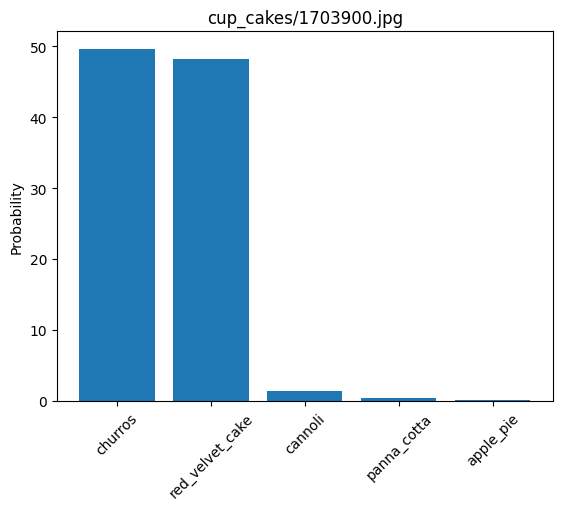

In [7]:
misclassified_index = np.where(predictions != Y_test)
#class_correct = Y_test[misclassified_index]
class_correct = (misclassified_index[:][0] // 20) % 20
class_wrong= predictions[misclassified_index]
in_class_pos = misclassified_index - class_correct*20
class_names_correct = [classes[i] for i in class_correct]
class_names_wrong = [classes[i] for i in class_wrong]

#create an array of two rows. The first contains the class names, the second the positions of the images misclassified in the class
misclassified_info = np.array([class_names_correct, in_class_pos])

for name_correct, pos, name_wrong in zip(class_names_correct,in_class_pos[0],class_names_wrong):
    c = os.listdir('Data_gitignore/cake-classification/test/' + name_correct)
    print(f"image '{c[pos]}' of class {name_correct} is misclassified as {name_wrong}")

cnn = pvml.CNN.load('Trained_models/cnn_transfer_gitignore.npz')
c_list, p_list = ccf.item_prediction('cup_cakes/1703900.jpg', classes, cnn, show = True)


### 2.3 NEURAL FEATURES
##### Try to use neural features computed by different hidden layers. When the activations are spatially distributed, you may reduce them to a single feature vector by averaging over the spatial dimensions.

In [53]:
def extract_neural_features(im, net, act_layer):
    activations = net.forward(im[None, :, :, :])  # one more dimension, from 224x244x3 to 1x224x244x3
    features = activations[act_layer]
    #print(activations[act_layer].shape)
    features = features.reshape(-1)
    #print(features.shape)
    # for feature in features:
        # print(feature.shape)
    return features

def dir_feat_neural(path, net, classes, act_layer):
    all_features = []
    all_labels = []
    for klass_label, klass in enumerate(classes):
        image_files = os.listdir(path + "/" + klass)
        for imagename in image_files:
            image_path = path + "/" + klass + "/" + imagename
            image = plt.imread(image_path) / 255.0
            #print(image_path)
            features = extract_neural_features(image, net, act_layer)
            all_features.append(features)
            all_labels.append(klass_label)
    X = np.stack(all_features, 0)
    Y = np.array(all_labels)
    return X, Y

In [61]:
act_layer = -7
classes = os.listdir("Data_gitignore/cake-classification/test")
path = 'Data_gitignore/cake-classification/test/'
cnn = pvml.CNN.load("Trained_models/pvmlnet.npz")
f = extract_neural_features(plt.imread(path+'cup_cakes/1703900.jpg'), cnn, act_layer)

X, Y = dir_feat_neural("Data_gitignore/cake-classification/test", cnn, classes, act_layer)
print("test", X.shape, Y.shape)
data = np.concatenate([X, Y[:, None]], 1)
np.savetxt(f"Features/neural{act_layer}_test.txt.gz", data)


X, Y = dir_feat_neural("Data_gitignore/cake-classification/train", cnn, classes, act_layer)
print("train", X.shape, Y.shape)
data = np.concatenate([X, Y[:, None]], 1)
np.savetxt(f"Features/neural{act_layer}_train.txt.gz", data)

test (300, 25088) (300,)
train (1500, 25088) (1500,)


In [62]:
#TRAIN A MULTI-LAYER PERCEPTRON TO CLASSIFY THE IMAGES
data = np.loadtxt(f"Features/neural{act_layer}_train.txt.gz")
X_train = data[:, :-1]
Y_train = data[:, -1].astype(int)

data = np.loadtxt(f"Features/neural{act_layer}_test.txt.gz")
X_test = data[:, :-1]
Y_test = data[:, -1].astype(int)

nclasses = Y_train.max() + 1

mlp = pvml.MLP([X_train.shape[1], nclasses])
epochs = 5000
batch_size = 50
train_accs, test_accs = ccf.train_MLP(mlp, X_train, Y_train, X_test, Y_test, epochs, batch_size, model_name = f'cnn{act_layer}_mlp', filename = f'cnn{act_layer}_accs',store_model=True, store_accs = True)

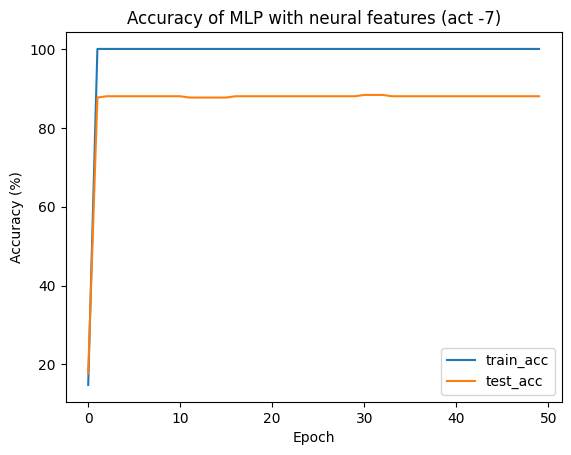

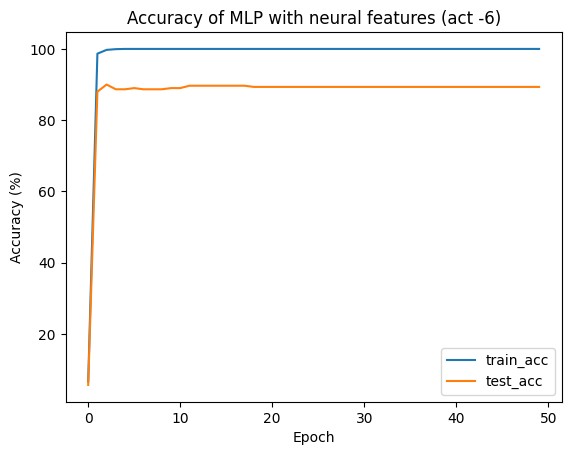

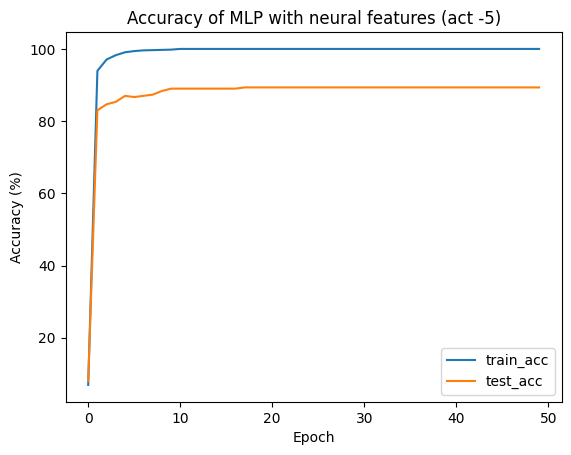

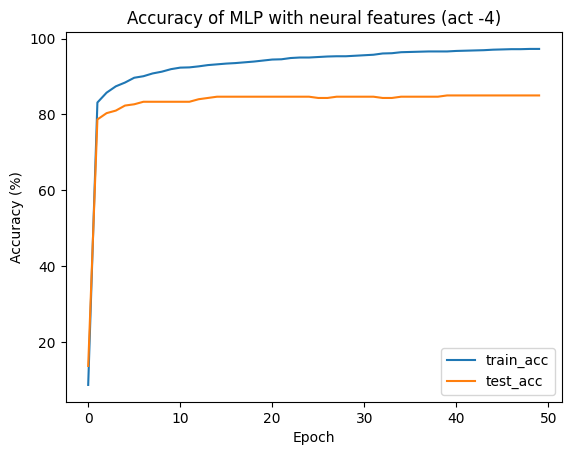

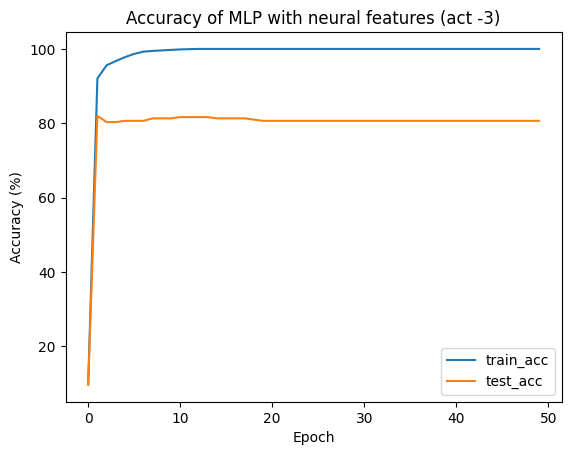

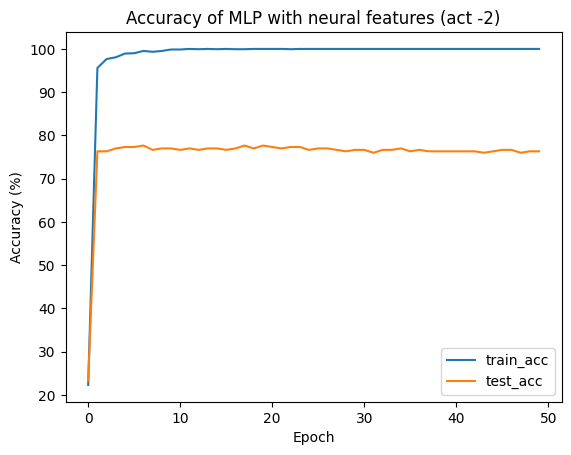

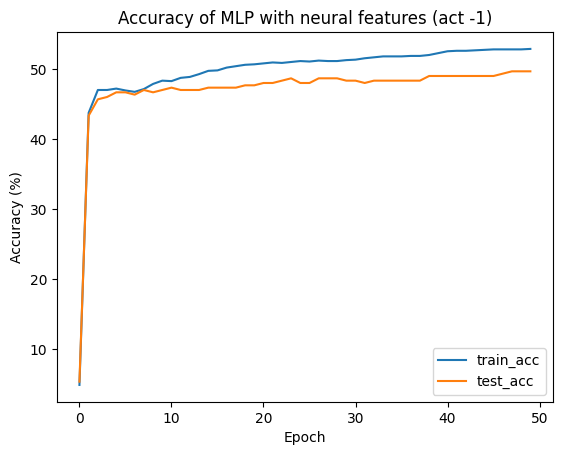

In [63]:
act_layers = [-7, -6, -5, -4, -3, -2, -1]
for act_layer in act_layers:
    df_accs = pd.read_csv(f'Results/cnn{act_layer}_accs.csv')
    df_accs.plot(x = 'epoch', y = ['train_acc', 'test_acc'], title = f'Accuracy of MLP with neural features (act {act_layer})', xlabel = 'Epoch', ylabel = 'Accuracy (%)')

### 2.4 FINE TUNING
##### Try to fine-tune the CNN after transfer learning (i.e. continue training with as very small learning rate like 10−5).